## spark MLlib

In [1]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, sum, date_format
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline

In [2]:
spark = SparkSession.builder.appName("lab4").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/19 11:59:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


1-get files contents

In [3]:
df = spark.read.csv('./tp4_data', header=True, inferSchema=True)

In [4]:
df.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   537226|    22811|SET OF 6 T-LIGHTS...|       6|2010-12-06 08:34:00|     2.95|   15987.0|United Kingdom|
|   537226|    21713|CITRONELLA CANDLE...|       8|2010-12-06 08:34:00|      2.1|   15987.0|United Kingdom|
|   537226|    22927|GREEN GIANT GARDE...|       2|2010-12-06 08:34:00|     5.95|   15987.0|United Kingdom|
|   537226|    20802|SMALL GLASS SUNDA...|       6|2010-12-06 08:34:00|     1.65|   15987.0|United Kingdom|
|   537226|    22052|VINTAGE CARAVAN G...|      25|2010-12-06 08:34:00|     0.42|   15987.0|United Kingdom|
|   537226|    22705|   WRAP GREEN PEARS |      25|2010-12-06 08:34:00|     0.42|   15987.0|United Kingdom|
|   537226|    20781|GOLD EA

2-display the schema

In [5]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



3-fill missing values with 0

In [6]:
df.select([sum(col(column).isNull().cast('int')).alias(column) for column in df.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|        140|       0|          0|        0|     16681|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [7]:
df = df.fillna(0)

In [8]:
df.select([sum(col(column).isNull().cast('int')).alias(column) for column in df.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|        140|       0|          0|        0|         0|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [9]:
df = df.fillna({'description': 'unknown'})

In [10]:
df.select([sum(col(column).isNull().cast('int')).alias(column) for column in df.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|          0|       0|          0|        0|         0|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



4-add 'day_of_week' column

In [11]:
df = df.withColumn('day_of_week', date_format(col('InvoiceDate'), 'EEEE'))

In [12]:
df.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|day_of_week|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+
|   537226|    22811|SET OF 6 T-LIGHTS...|       6|2010-12-06 08:34:00|     2.95|   15987.0|United Kingdom|     Monday|
|   537226|    21713|CITRONELLA CANDLE...|       8|2010-12-06 08:34:00|      2.1|   15987.0|United Kingdom|     Monday|
|   537226|    22927|GREEN GIANT GARDE...|       2|2010-12-06 08:34:00|     5.95|   15987.0|United Kingdom|     Monday|
|   537226|    20802|SMALL GLASS SUNDA...|       6|2010-12-06 08:34:00|     1.65|   15987.0|United Kingdom|     Monday|
|   537226|    22052|VINTAGE CARAVAN G...|      25|2010-12-06 08:34:00|     0.42|   15987.0|United Kingdom|     Monday|
|   537226|    22705|   WRAP GREEN PEARS

In [13]:
df.select('day_of_week').distinct().show()

+-----------+
|day_of_week|
+-----------+
|  Wednesday|
|    Tuesday|
|     Friday|
|   Thursday|
|     Monday|
|     Sunday|
+-----------+



5-split data into training/test

In [14]:
training_set = df.filter(col("InvoiceDate") < '2010-12-13')
test_set = df.filter(col("InvoiceDate") >= '2010-12-13')

In [15]:
training_set.count(), len(training_set.columns)

(26732, 9)

In [16]:
test_set.count(), len(test_set.columns)

(18676, 9)

6-convert day_of_week to numerical values with StringIndexer

In [17]:
indexer = StringIndexer(inputCol='day_of_week', outputCol='day')
df = indexer.fit(df).transform(df)

In [18]:
df.select('day_of_week', 'day').distinct().show()

+-----------+---+
|day_of_week|day|
+-----------+---+
|   Thursday|4.0|
|  Wednesday|0.0|
|     Sunday|5.0|
|     Friday|1.0|
|    Tuesday|3.0|
|     Monday|2.0|
+-----------+---+



7-one hot encoding

In [19]:
encoder = OneHotEncoder(inputCols=['day'], outputCols=['day_of_week_encoded'])
df = encoder.fit(df).transform(df)

In [20]:
df.select('day_of_week', 'day', 'day_of_week_encoded').distinct().show()

+-----------+---+-------------------+
|day_of_week|day|day_of_week_encoded|
+-----------+---+-------------------+
|     Sunday|5.0|          (5,[],[])|
|    Tuesday|3.0|      (5,[3],[1.0])|
|   Thursday|4.0|      (5,[4],[1.0])|
|     Friday|1.0|      (5,[1],[1.0])|
|     Monday|2.0|      (5,[2],[1.0])|
|  Wednesday|0.0|      (5,[0],[1.0])|
+-----------+---+-------------------+



8-vector assembler

In [21]:
assembler = VectorAssembler(inputCols=['UnitPrice', 'Quantity', 'day_of_week_encoded'], outputCol='vector_feature')
df = assembler.transform(df)

In [22]:
df.select("InvoiceDate", "UnitPrice", "Quantity", "day_of_week", "day_of_week_encoded", "vector_feature").show(truncate=False)

+-------------------+---------+--------+-----------+-------------------+----------------------------+
|InvoiceDate        |UnitPrice|Quantity|day_of_week|day_of_week_encoded|vector_feature              |
+-------------------+---------+--------+-----------+-------------------+----------------------------+
|2010-12-06 08:34:00|2.95     |6       |Monday     |(5,[2],[1.0])      |(7,[0,1,4],[2.95,6.0,1.0])  |
|2010-12-06 08:34:00|2.1      |8       |Monday     |(5,[2],[1.0])      |(7,[0,1,4],[2.1,8.0,1.0])   |
|2010-12-06 08:34:00|5.95     |2       |Monday     |(5,[2],[1.0])      |(7,[0,1,4],[5.95,2.0,1.0])  |
|2010-12-06 08:34:00|1.65     |6       |Monday     |(5,[2],[1.0])      |(7,[0,1,4],[1.65,6.0,1.0])  |
|2010-12-06 08:34:00|0.42     |25      |Monday     |(5,[2],[1.0])      |(7,[0,1,4],[0.42,25.0,1.0]) |
|2010-12-06 08:34:00|0.42     |25      |Monday     |(5,[2],[1.0])      |(7,[0,1,4],[0.42,25.0,1.0]) |
|2010-12-06 08:34:00|5.49     |2       |Monday     |(5,[2],[1.0])      |(7,[0,1,4]

using pipeline

In [23]:
pipeline_indexer = StringIndexer(inputCol='day_of_week', outputCol='day_pipeline')
pipeline_encoder = OneHotEncoder(inputCols=['day_pipeline'], outputCols=['day_of_week_encoded_pipeline'])
pipeline_assembler = VectorAssembler(inputCols=['UnitPrice', 'Quantity', 'day_of_week_encoded_pipeline'], outputCol='vector_feature_pipeline')

pipeline = Pipeline(stages=[pipeline_indexer, pipeline_encoder, pipeline_assembler])
df = pipeline.fit(df).transform(df)

In [24]:
df.select("InvoiceDate", "UnitPrice", "Quantity", "day_of_week", "day_pipeline", "day_of_week_encoded_pipeline", "vector_feature_pipeline").show()


+-------------------+---------+--------+-----------+------------+----------------------------+-----------------------+
|        InvoiceDate|UnitPrice|Quantity|day_of_week|day_pipeline|day_of_week_encoded_pipeline|vector_feature_pipeline|
+-------------------+---------+--------+-----------+------------+----------------------------+-----------------------+
|2010-12-06 08:34:00|     2.95|       6|     Monday|         2.0|               (5,[2],[1.0])|   (7,[0,1,4],[2.95,...|
|2010-12-06 08:34:00|      2.1|       8|     Monday|         2.0|               (5,[2],[1.0])|   (7,[0,1,4],[2.1,8...|
|2010-12-06 08:34:00|     5.95|       2|     Monday|         2.0|               (5,[2],[1.0])|   (7,[0,1,4],[5.95,...|
|2010-12-06 08:34:00|     1.65|       6|     Monday|         2.0|               (5,[2],[1.0])|   (7,[0,1,4],[1.65,...|
|2010-12-06 08:34:00|     0.42|      25|     Monday|         2.0|               (5,[2],[1.0])|   (7,[0,1,4],[0.42,...|
|2010-12-06 08:34:00|     0.42|      25|     Mon

In [25]:
def comparaison(x, y):
    return x == y

df = df.withColumn('comparaison', comparaison(col('day_of_week_encoded'), col('day_of_week_encoded_pipeline')))

In [26]:
df.select('comparaison').distinct().show()

+-----------+
|comparaison|
+-----------+
|       true|
+-----------+



11-transform training set using pipeline

In [27]:
training_set = pipeline.fit(training_set).transform(training_set)

12-kmeans with clusters=20

In [28]:
kmeans = KMeans(k=20)

13-training the kmeans model

In [29]:
training_set = training_set.withColumnRenamed("vector_feature_pipeline", "features")

In [30]:
model = kmeans.fit(training_set)

25/02/19 11:59:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


14-prediction

In [31]:
test_set = pipeline.fit(test_set).transform(test_set)
test_set = test_set.withColumnRenamed('vector_feature_pipeline', 'features')

In [32]:
prediction = model.transform(test_set)

15-calculate the silhoutte coefficient

In [33]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(prediction)

In [34]:
silhouette

0.5940039478590249

In [35]:
kmeans_2 = KMeans(k=3)

In [36]:
model_2 = kmeans_2.fit(training_set)

In [37]:
prediction_2 = model_2.transform(test_set)

In [38]:
silhouette_2 = evaluator.evaluate(prediction_2)

In [39]:
silhouette_2

0.9999871570618726

K=2, Silhouette Score=0.9999, WCSS=215668244.97


K=3, Silhouette Score=0.9998, WCSS=141043339.62


K=4, Silhouette Score=0.9999, WCSS=53292035.05


K=5, Silhouette Score=0.9989, WCSS=29089943.71
K=6, Silhouette Score=0.9980, WCSS=17887342.59
K=7, Silhouette Score=0.9961, WCSS=12996922.20
K=8, Silhouette Score=0.9904, WCSS=12293704.35


K=9, Silhouette Score=0.9886, WCSS=14011012.05
K=10, Silhouette Score=0.9903, WCSS=8849767.42


K=11, Silhouette Score=0.8817, WCSS=6180958.09
K=12, Silhouette Score=0.8816, WCSS=5475927.46


K=13, Silhouette Score=0.8818, WCSS=4524414.66


K=14, Silhouette Score=0.8825, WCSS=4401689.48
K=15, Silhouette Score=0.8798, WCSS=3078784.57
K=16, Silhouette Score=0.5813, WCSS=2791208.15


K=17, Silhouette Score=0.6123, WCSS=2372970.16


K=18, Silhouette Score=0.6393, WCSS=1842968.17
K=19, Silhouette Score=0.6395, WCSS=1677731.99
K=20, Silhouette Score=0.6573, WCSS=1490610.45


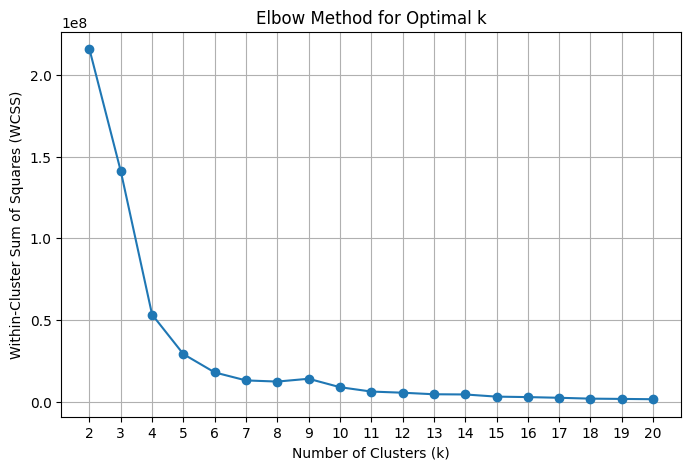

In [41]:
import numpy as np
import matplotlib.pyplot as plt

k_values = range(2, 21)  
wcss = [] 

for k in k_values:
    kmeans = KMeans(k=k, featuresCol="features")
    model = kmeans.fit(training_set)
    predictions = model.transform(training_set)

    # Compute WCSS (Inertia)
    evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette")
    silhouette = evaluator.evaluate(predictions)
    
    # Get WCSS from model summary
    wcss.append(model.summary.trainingCost)

    print(f"K={k}, Silhouette Score={silhouette:.4f}, WCSS={model.summary.trainingCost:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_values)
plt.grid()
plt.show()
